## Typical LISA experiment

This notebook shows a typical LISA-use case:

* Connecting to a target
* Configuring an rt-app workload
* Collecting a trace while executing a workload
* Displaying the trace
* Analysing the trace

It can serve as a template for different kind of experiments, - you could only change the workload to execute & the trace events to collect

In [1]:
import logging
from lisa.utils import setup_logging
setup_logging()

2019-03-01 15:34:41,011 INFO    : root         : Using LISA logging configuration:
2019-03-01 15:34:41,012 INFO    : root         :   /data/work/lisa/logging.conf


## Target configuration

Target communication is abstracted away under a **Target** class. We're going to create an instance of it and that'll let us run whatever experiment we want on a given target.

Relevant documentation:
* **Target**: https://lisa-linux-integrated-system-analysis.readthedocs.io/en/master/target.html#lisa.target.Target
* **TargetConf**: https://lisa-linux-integrated-system-analysis.readthedocs.io/en/master/target.html#lisa.target.TargetConf

In [2]:
from lisa.target import Target, TargetConf

2019-03-01 15:34:41,028 INFO    : root         : Generating grammar tables from /usr/lib/python3.5/lib2to3/Grammar.txt
2019-03-01 15:34:41,051 INFO    : root         : Generating grammar tables from /usr/lib/python3.5/lib2to3/PatternGrammar.txt


In [3]:
target = Target(
    kind='linux',
    name='myhikey960',
    host='192.168.0.1',
    username='root',
    password='root',
)

2019-03-01 15:34:41,718 INFO    : lisa.target.Target : Creating result directory: /data/work/lisa/results/Target-myhikey960-20190301_153441.718070
2019-03-01 15:34:41,720 INFO    : lisa.target.Target : linux myhikey960 target connection settings:
2019-03-01 15:34:41,721 INFO    : lisa.target.Target :   username : root
2019-03-01 15:34:41,722 INFO    : lisa.target.Target :       host : 192.168.0.1
2019-03-01 15:34:41,723 INFO    : lisa.target.Target :   password : root
2019-03-01 15:34:41,723 INFO    : lisa.target.Target :       port : 22
2019-03-01 15:34:41,738 INFO    : lisa.target.Target : Devlib modules to load: bl, cgroups, cpufreq, cpuidle, devfreq, fastboot, gem5stats, gpufreq, hotplug, hwmon, mbed-fan, odroidxu3-fan, sched, thermal
2019-03-01 15:34:46,707 WARNING : LinuxTarget  : Module devfreq is not supported by the target
2019-03-01 15:34:46,710 WARNING : LinuxTarget  : Module fastboot is not supported by the target
2019-03-01 15:34:46,711 WARNING : LinuxTarget  : Module gem5

## Setting up an rt-app workload

rt-app is very convenient for scheduler experiments, and the majority of the tests within LISA rely on it. Here we're going to create a somewhat useless workload just to show off the API.

Relevant documentation:
* **rt-app**: https://github.com/scheduler-tools/rt-app
* **rt-app LISA class**: https://lisa-linux-integrated-system-analysis.readthedocs.io/en/master/workloads.html#lisa.wlgen.rta.RTA
* **Periodic class**: https://lisa-linux-integrated-system-analysis.readthedocs.io/en/master/workloads.html#lisa.wlgen.rta.Periodic

In [4]:
from lisa.wlgen.rta import RTA, Periodic

In [5]:
rtapp_profile = {}

for cpu in range(target.number_of_cpus):
    for i in range(3):
        rtapp_profile["task_{}_{}".format(cpu, i)] = Periodic(duty_cycle_pct=20)

rt-app needs some calibration information (20% duty cycle isn't the same amount of work on all platforms!). It can be manually specified like so:

In [6]:
def provide_calibration(calibration):
    target.plat_info["rtapp"].add_src("user", {"calib" : calibration})

In [7]:
# Uncomment if you want to use this
# provide_calibration({0: 307, 1: 302, 2: 302, 3: 302, 4: 155, 5: 155, 6: 155, 7: 155})

However, it is automatically collected when first creating an rt-app workload if it is not specified, so you can forego the above step and let the calibration happen on-demand:

In [8]:
wload = RTA.by_profile(target, "experiment_wload", rtapp_profile)

2019-03-01 15:35:02,208 INFO    : lisa.target.Target : Creating result directory: /data/work/lisa/results/Target-myhikey960-20190301_153441.718070/RTA-experiment_wload-20190301_153502.207999
2019-03-01 15:35:13,050 INFO    : lisa.wlgen.rta.RTA : CPU0 calibration...
2019-03-01 15:35:13,385 INFO    : lisa.wlgen.rta.RTA : Calibration value: CPU0
2019-03-01 15:35:13,386 INFO    : lisa.wlgen.rta.RTA : Default policy: SCHED_OTHER
2019-03-01 15:35:13,387 INFO    : lisa.wlgen.rta.RTA : ------------------------
2019-03-01 15:35:13,389 INFO    : lisa.wlgen.rta.RTA : task [task1], sched: using default policy
2019-03-01 15:35:13,390 INFO    : lisa.wlgen.rta.RTA :  | start delay: 0.000000 [s]
2019-03-01 15:35:13,392 INFO    : lisa.wlgen.rta.RTA :  | loops count: 1
2019-03-01 15:35:13,393 INFO    : lisa.wlgen.rta.RTA :  + phase_000001
2019-03-01 15:35:13,395 INFO    : lisa.wlgen.rta.Phase :  | batch 0.001000 [s]
2019-03-01 15:35:13,643 INFO    : lisa.wlgen.rta.RTA : Execution start: /root/devlib-tar

2019-03-01 15:36:18,264 INFO    : lisa.wlgen.rta.RTA :  | start delay: 0.000000 [s]
2019-03-01 15:36:18,265 INFO    : lisa.wlgen.rta.RTA :  | loops count: 1
2019-03-01 15:36:18,266 INFO    : lisa.wlgen.rta.RTA :  + phase_000001
2019-03-01 15:36:18,267 INFO    : lisa.wlgen.rta.Phase :  | duration 1.000000 [s] (10 loops)
2019-03-01 15:36:18,269 INFO    : lisa.wlgen.rta.Phase :  |  period   100000 [us], duty_cycle  20 %
2019-03-01 15:36:18,270 INFO    : lisa.wlgen.rta.Phase :  |  run_time  20000 [us], sleep_time  80000 [us]
2019-03-01 15:36:18,271 INFO    : lisa.wlgen.rta.RTA : ------------------------
2019-03-01 15:36:18,272 INFO    : lisa.wlgen.rta.RTA : task [task_2_1], sched: using default policy
2019-03-01 15:36:18,273 INFO    : lisa.wlgen.rta.RTA :  | start delay: 0.000000 [s]
2019-03-01 15:36:18,274 INFO    : lisa.wlgen.rta.RTA :  | loops count: 1
2019-03-01 15:36:18,275 INFO    : lisa.wlgen.rta.RTA :  + phase_000001
2019-03-01 15:36:18,276 INFO    : lisa.wlgen.rta.Phase :  | durat

2019-03-01 15:36:18,364 INFO    : lisa.wlgen.rta.Phase :  |  run_time  20000 [us], sleep_time  80000 [us]
2019-03-01 15:36:18,365 INFO    : lisa.wlgen.rta.RTA : ------------------------
2019-03-01 15:36:18,366 INFO    : lisa.wlgen.rta.RTA : task [task_4_1], sched: using default policy
2019-03-01 15:36:18,366 INFO    : lisa.wlgen.rta.RTA :  | start delay: 0.000000 [s]
2019-03-01 15:36:18,367 INFO    : lisa.wlgen.rta.RTA :  | loops count: 1
2019-03-01 15:36:18,367 INFO    : lisa.wlgen.rta.RTA :  + phase_000001
2019-03-01 15:36:18,368 INFO    : lisa.wlgen.rta.Phase :  | duration 1.000000 [s] (10 loops)
2019-03-01 15:36:18,368 INFO    : lisa.wlgen.rta.Phase :  |  period   100000 [us], duty_cycle  20 %
2019-03-01 15:36:18,369 INFO    : lisa.wlgen.rta.Phase :  |  run_time  20000 [us], sleep_time  80000 [us]
2019-03-01 15:36:18,370 INFO    : lisa.wlgen.rta.RTA : ------------------------
2019-03-01 15:36:18,370 INFO    : lisa.wlgen.rta.RTA : task [task_4_2], sched: using default policy
2019-03

2019-03-01 15:36:18,430 INFO    : lisa.wlgen.rta.RTA :  + phase_000001
2019-03-01 15:36:18,431 INFO    : lisa.wlgen.rta.Phase :  | duration 1.000000 [s] (10 loops)
2019-03-01 15:36:18,432 INFO    : lisa.wlgen.rta.Phase :  |  period   100000 [us], duty_cycle  20 %
2019-03-01 15:36:18,432 INFO    : lisa.wlgen.rta.Phase :  |  run_time  20000 [us], sleep_time  80000 [us]


## Running the workload

In [9]:
import os
from lisa.trace import FtraceCollector

We need to specify the trace events we want to record. We could list what's available like so:

In [10]:
available_events = target.execute("cat /sys/kernel/debug/tracing/available_events").splitlines()

# That's gonna be a pretty big list, let's focus on the scheduler events
sched_events = [event for event in available_events if event.startswith("sched:")]
print(sched_events)

['sched:uclamp_util_cfs', 'sched:uclamp_util_se', 'sched:sched_overutilized', 'sched:sched_compute_energy', 'sched:sched_util_est_cpu', 'sched:sched_util_est_task', 'sched:sched_load_tg', 'sched:sched_load_se', 'sched:sched_load_cfs_rq', 'sched:sched_wake_idle_without_ipi', 'sched:sched_swap_numa', 'sched:sched_stick_numa', 'sched:sched_move_numa', 'sched:sched_pi_setprio', 'sched:sched_stat_runtime', 'sched:sched_stat_blocked', 'sched:sched_stat_iowait', 'sched:sched_stat_sleep', 'sched:sched_stat_wait', 'sched:sched_process_exec', 'sched:sched_process_fork', 'sched:sched_process_wait', 'sched:sched_wait_task', 'sched:sched_process_exit', 'sched:sched_process_free', 'sched:sched_migrate_task', 'sched:sched_switch', 'sched:sched_wakeup_new', 'sched:sched_wakeup', 'sched:sched_waking', 'sched:sched_kthread_stop_ret', 'sched:sched_kthread_stop']


Let's just collect the base events required to plot task scheduling:

In [11]:
events = [
    "sched_switch",
    "sched_wakeup",
    "sched_wakeup_new"
]

And now we can actually record traces while running our workload:

In [12]:
ftrace_coll = FtraceCollector(target, events=events, buffer_size=10240)

# This is just nifty Python syntactic sugar that starts/stops
# the recording for us. You could just do:
#     ftrace.start()
#     wload.run()
#     ftrace.stop()
#     ftrace.get_trace(trace_path)
trace_path = os.path.join(wload.res_dir, "trace.dat")
with ftrace_coll:
    wload.run()
ftrace_coll.get_trace(trace_path)

2019-03-01 15:36:25,413 INFO    : lisa.wlgen.rta.RTA : Execution start: /root/devlib-target/bin/rt-app /root/devlib-target/experiment_wload.json 2>&1
2019-03-01 15:36:26,682 INFO    : lisa.wlgen.rta.RTA : Execution complete


## Loading up the trace

We have a Trace class that lets us easily access trace events. It can also do some post-processing to provide different kinds of analysis.

In [13]:
from lisa.trace import Trace

We also save some platform information (number of CPUs, available frequencies, kernel version...) that comes in handy for doing some analysis:

In [14]:
print(target.plat_info)

|- abi from target (str): arm64
|- cpu-capacities from target (dict): {0: 462, 1: 462, 2: 462, 3: 462, 4: 1024, 5: 1024, 6: 1024, 7: 1024}
|- cpus-count from target (int): 8
|- freq-domains from target (list): [[0, 1, 2, 3], [4, 5, 6, 7]]
|- freqs from target (dict): {0: [533000, 999000, 1402000, 1709000, 1844000], 1: [533000, 999000, 1402000, 1709000, 1844000], 2: [533000, 999000, 1402000, 1709000, 1844000], 3: [533000, 999000, 1402000, 1709000, 1844000], 4: [903000, 1421000, 1805000, 2112000, 2362000], 5: [903000, 1421000, 1805000, 2112000, 2362000], 6: [903000, 1421000, 1805000, 2112000, 2362000], 7: [903000, 1421000, 1805000, 2112000, 2362000]}
+- kernel:
    |- config from target (TypedKernelConfig): <kernel config>
    |- version from target (KernelVersion): 5.0.0-rc6-00099-g5441513e6c1c 29 SMP PREEMPT Tue Feb 26 16:27:53 GMT 2019
|- name from target-conf (str): myhikey960
|- nrg-model from target (EnergyModel): <lisa.energy_model.EnergyModel object at 0x7f4aa4af1208>
|- os from 

You can pass the platform info directly from the **Target**:

In [15]:
trace_path = os.path.join(wload.res_dir, 'trace.dat')
trace = Trace(trace_path, target.plat_info, events=events)

... But it's a good idea to save it on the disk so that you can re-run whatever analysis code you want several months down the line after the platform was lost in a tragic fire.

It's why we save this information somewhere instead of polling the target when we want to use them - we can run analysis code offline.

Here we show how to save to/restore this platform information from the disk.

In [16]:
plat_info_path = os.path.join(wload.res_dir, "platinfo.yaml")
target.plat_info.to_yaml_map(plat_info_path)

In [17]:
from lisa.platforms.platinfo import PlatformInfo

In [18]:
plat_info = PlatformInfo.from_yaml_map(plat_info_path)
trace = Trace(trace_path, plat_info, events=events)

## Looking at the trace

Kernelshark can be opened from the notebook:

In [19]:
!kernelshark {trace_path}

version = 6
trace-cmd: No such file or directory
  [xhci-hcd:xhci_urb_giveback] bad op token {
  [xhci-hcd:xhci_urb_enqueue] bad op token {
  [xhci-hcd:xhci_urb_dequeue] bad op token {
  [xhci-hcd:xhci_setup_device_slot] function xhci_decode_slot_context not defined
  [xhci-hcd:xhci_ring_free] function xhci_ring_type_string not defined
  [xhci-hcd:xhci_ring_expansion] function xhci_ring_type_string not defined
  [xhci-hcd:xhci_ring_alloc] function xhci_ring_type_string not defined
  [xhci-hcd:xhci_queue_trb] function xhci_ring_type_string not defined
  [xhci-hcd:xhci_inc_enq] function xhci_ring_type_string not defined
  [xhci-hcd:xhci_inc_deq] function xhci_ring_type_string not defined
  [xhci-hcd:xhci_hub_status_data] function xhci_decode_portsc not defined
  [xhci-hcd:xhci_handle_transfer] function xhci_ring_type_string not defined
  [xhci-hcd:xhci_handle_port_status] function xhci_decode_portsc not defined
  [xhci-hcd:xhci_handle_event] function xhci_ring_type_string not defined
  [

## Analysing the trace

Relevant documentation: https://lisa-linux-integrated-system-analysis.readthedocs.io/en/master/trace_analysis.html

### Reading trace events

In [20]:
df = trace.df_events("sched_switch")
df

,__comm,__cpu,__line,__pid,next_comm,next_pid,next_prio,prev_comm,prev_pid,prev_prio,prev_state
Time,,,,,,,,,,,
0.000032,<...>,6,1,6483,swapper/6,0,120,trace-cmd,6483,120,32
0.000074,<idle>,6,3,0,kworker/6:3,5273,120,swapper/6,0,120,0
0.000119,kworker/6:3,6,4,5273,swapper/6,0,120,kworker/6:3,5273,120,128
0.000256,<idle>,4,5,0,bash,5870,120,swapper/4,0,120,0
0.001179,<idle>,7,7,0,kworker/u16:0,4002,120,swapper/7,0,120,0
0.001237,kworker/u16:0,7,8,4002,swapper/7,0,120,kworker/u16:0,4002,120,128
0.001379,bash,4,10,5870,swapper/4,0,120,bash,5870,120,1
0.001569,<idle>,7,11,0,kworker/u16:0,4002,120,swapper/7,0,120,0
0.001599,kworker/u16:0,7,12,4002,swapper/7,0,120,kworker/u16:0,4002,120,128


The standard DataFrame operations are available, so you can filter/slice it however you wish:

In [21]:
df[df.next_comm == "task_4_1"][1.5:2]

,__comm,__cpu,__line,__pid,next_comm,next_pid,next_prio,prev_comm,prev_pid,prev_prio,prev_state
Time,,,,,,,,,,,
1.548015,<...>,4,2729,6505,task_4_1,6518,120,task_6_1,6505,120,0
1.578698,<...>,5,2759,6519,task_4_1,6518,120,task_4_2,6519,120,1
1.647798,<...>,7,2876,6524,task_4_1,6518,120,task_2_0,6524,120,0
1.662851,<...>,4,2893,6516,task_4_1,6518,120,task_6_0,6516,120,1
1.747797,<idle>,4,3300,0,task_4_1,6518,120,swapper/4,0,120,0


### Using the trace analysis

#### Example dataframes

In [22]:
trace.analysis.tasks.df_tasks_runtime()

,comm,runtime
pid,,
0,swapper/6,7.431009
1,systemd,0.557442
6512,task_1_0,0.361172
6506,task_2_1,0.340199
6520,task_0_2,0.334197
6523,task_1_2,0.328273
6507,task_0_1,0.323451
6515,task_3_1,0.320666
6509,task_7_0,0.301623


In [23]:
df = trace.analysis.tasks.df_task_states("task_4_1", stringify=True)
df

,cpu,target_cpu,curr_state,delta,next_state,curr_state_str,next_state_str
Time,,,,,,,
0.746533,6,4,512,0.000204,8192,W,A
0.746737,4,-1,8192,0.000072,2,A,D
0.746809,4,-1,2,0.000011,512,D,W
0.746820,5,4,512,0.000004,8192,W,A
0.746824,4,-1,8192,0.000020,1,A,S
0.746844,4,-1,1,0.006621,512,S,W
0.753465,4,4,512,0.000013,8192,W,A
0.753478,4,-1,8192,0.000013,1,A,S
0.753491,4,-1,1,0.000234,512,S,W


In [24]:
from lisa.analysis.tasks import TaskState

In [25]:
df[df.curr_state == TaskState.TASK_ACTIVE][1:1.2]

,cpu,target_cpu,curr_state,delta,next_state,curr_state_str,next_state_str
Time,,,,,,,
1.018229,3,-1,8192,0.015539,1,A,S
1.054309,3,-1,8192,0.007927,0,A,R
1.082624,3,-1,8192,0.011606,0,A,R
1.110236,3,-1,8192,0.016008,0,A,R
1.126274,3,-1,8192,0.005738,1,A,S
1.178706,5,-1,8192,0.003450,0,A,R
1.194208,5,-1,8192,0.016000,0,A,R


#### Example plots

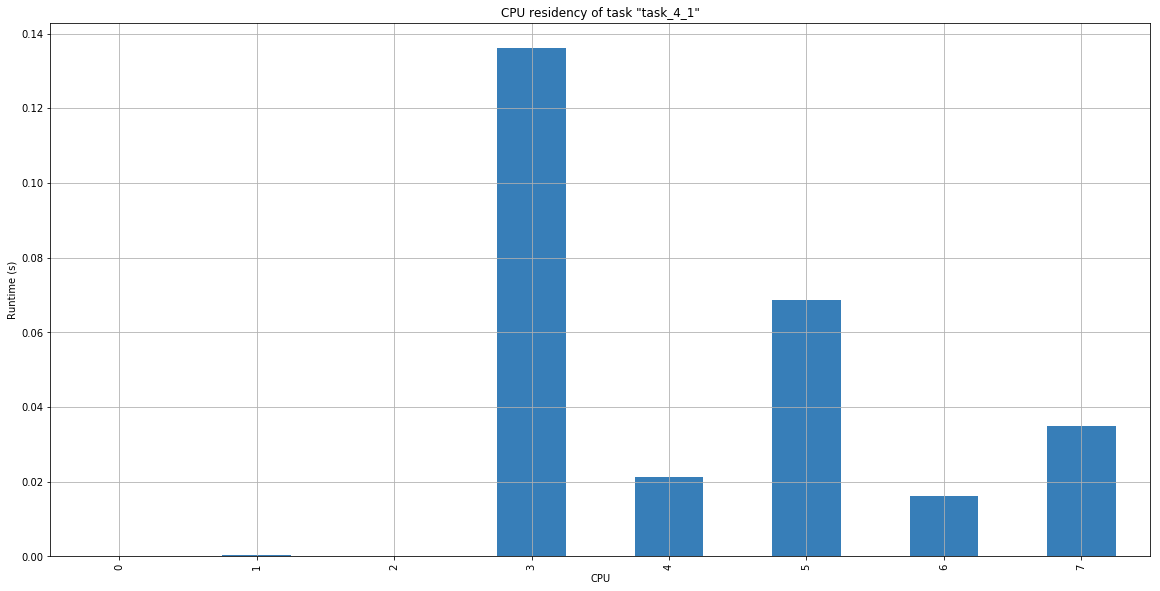

In [26]:
trace.analysis.tasks.plot_task_total_residency("task_4_1")

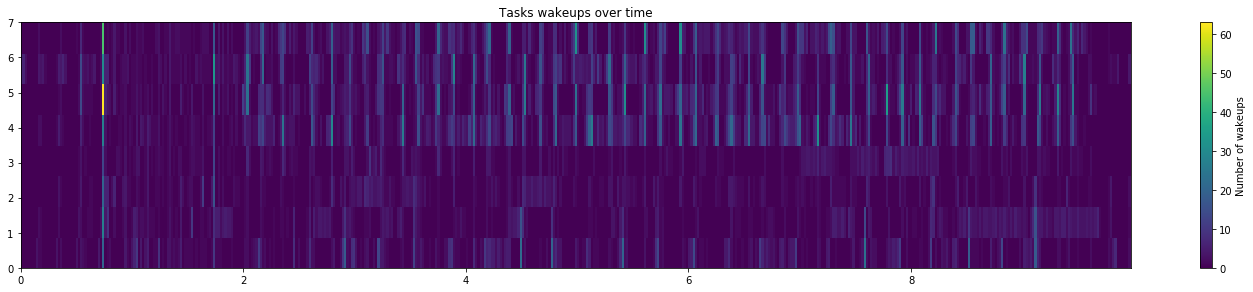

In [27]:
trace.analysis.tasks.plot_tasks_wakeups_heatmap(xbins=500)

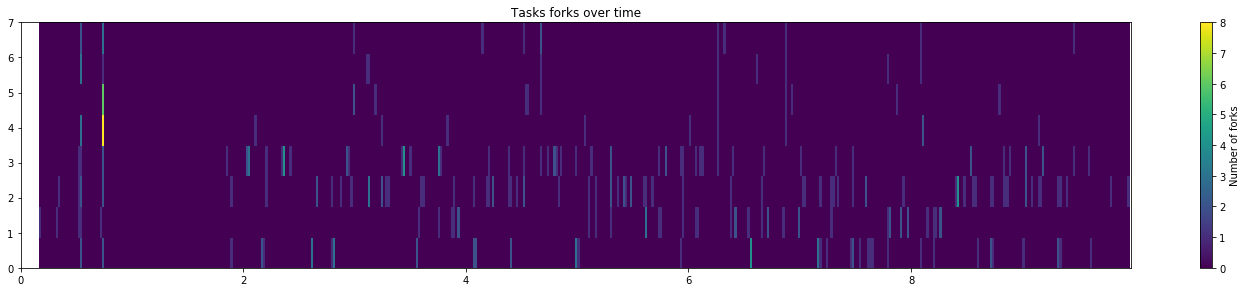

In [28]:
trace.analysis.tasks.plot_tasks_forks_heatmap(xbins=500)